# Image Colorization using CNN

### 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random

### 2. Load and Prepare Dataset

Dataset: 130k Images (128x128) - Universal Image Embeddings

Link: https://www.kaggle.com/datasets/rhtsingh/google-universal-image-embeddings-128x128/data

Here I am using LAB colour space instead of RGB. Why LAB is better for colorization?

- LAB separates luminance (L) from color (A and B), which aligns well with the colorization task (input only L and predict A and B).

- The model doesn't need to "guess" the brightness; it just learns to predict color.

- skimage converts RGB to LAB according to the CIE standard and returns values in physically meaningful ranges: L ∈ [0, 100]; a, b ∈ [-128, 127]

In [ ]:
# Download Dataset
# import kagglehub

# path = kagglehub.dataset_download("rhtsingh/google-universal-image-embeddings-128x128") # Download latest version

# path += "/128x128"

# print("Path to dataset files:", path)

path = "/dataset" # Paste path to dataset containing images in folders

Path to dataset files: /kaggle/input/google-universal-image-embeddings-128x128/128x128


In [122]:
# ========== LAB COLOR UTILITIES ==========
from skimage import color

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def lab_to_rgb(L, ab):
    L = to_numpy(L)
    ab = to_numpy(ab)
    if L.ndim == 3 and L.shape[0] == 1:
        L = L[0]
    if ab.shape[0] == 2:
        ab = ab.transpose(1, 2, 0)
    # Make sure both L and ab are NumPy and of the same dtype
    L = np.array(L, dtype=np.float32)
    ab = np.array(ab, dtype=np.float32)
    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
    lab[:, :, 0] = L * 100
    lab[:, :, 1:] = ab * 128
    rgb = color.lab2rgb(lab)
    rgb = np.clip(rgb, 0, 1)
    return rgb

def rgb_to_lab(img):
    # Ensure the input is a NumPy array before passing to skimage
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    lab = color.rgb2lab(img)
    L = lab[:, :, 0] / 100.0
    ab = lab[:, :, 1:] / 128.0
    return torch.tensor(L).unsqueeze(0), torch.tensor(ab).permute(2, 0, 1)


In [ ]:
# ========== Dataset Prepartion ==========
class LABColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.image_paths = []
        for class_folder in os.listdir(root_dir):
            class_folder_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_folder_path):
                for img_name in os.listdir(class_folder_path):
                    self.image_paths.append(os.path.join(class_folder_path, img_name))
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        img = self.transform(img)  # Resize and convert to tensor
        img_np = img.permute(1, 2, 0).numpy()  # (H, W, C)

        from skimage import color
        lab = color.rgb2lab(img_np).astype("float32")
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0

        L = torch.from_numpy(L).unsqueeze(0)        # (1, H, W)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # (2, H, W)
        return L, ab

    def __len__(self):
        return len(self.image_paths)


In [ ]:
# Dataset and Split
transform_resize = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = LABColorizationDataset(
    root_dir=path,
    transform=transform_resize
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [ ]:
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

Number of training samples: 119275
Number of test samples: 13253


### 3. Model Architecture (U-Net Style Model)

In [ ]:
class UNetColorization(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_ch, out_ch): return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU())

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec1 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = CBR(128, 64)

        self.final = nn.Conv2d(64, 2, kernel_size=1)  # Output: AB channels

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d1 = self.up1(e4)
        d1 = self.dec1(torch.cat([d1, e3], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim=1))
        return torch.tanh(self.final(d3))

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

Using device: cuda


### 4. Hyperparameters

In [ ]:
model = UNetColorization().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

### 5. Training Loop

In [ ]:
from tqdm import tqdm
import time

start_time = time.time()
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for gray, color in progress_bar:
        gray, color = gray.to(device), color.to(device)
        optimizer.zero_grad()
        output = model(gray)
        loss = criterion(output, color)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} completed. Avg Loss: {total_loss/len(train_loader):.4f}")
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), 'best_colorization_model.pth')

end_time = time.time()
elapsed_time = end_time - start_time

mins, secs = divmod(elapsed_time, 60)
print(f"\nTraining completed in {int(mins)} minutes and {int(secs)} seconds.")

Epoch 1/20: 100%|██████████| 932/932 [07:42<00:00,  2.02batch/s, loss=0.00854]


Epoch 1 completed. Avg Loss: 0.0112


Epoch 2/20: 100%|██████████| 932/932 [07:42<00:00,  2.02batch/s, loss=0.00865]


Epoch 2 completed. Avg Loss: 0.0094


Epoch 3/20: 100%|██████████| 932/932 [07:42<00:00,  2.02batch/s, loss=0.00859]


Epoch 3 completed. Avg Loss: 0.0092


Epoch 4/20: 100%|██████████| 932/932 [07:41<00:00,  2.02batch/s, loss=0.00917]


Epoch 4 completed. Avg Loss: 0.0090


Epoch 5/20: 100%|██████████| 932/932 [07:41<00:00,  2.02batch/s, loss=0.00807]


Epoch 5 completed. Avg Loss: 0.0089


Epoch 6/20: 100%|██████████| 932/932 [07:41<00:00,  2.02batch/s, loss=0.00714]


Epoch 6 completed. Avg Loss: 0.0087


Epoch 7/20: 100%|██████████| 932/932 [07:41<00:00,  2.02batch/s, loss=0.00892]


Epoch 7 completed. Avg Loss: 0.0086


Epoch 8/20: 100%|██████████| 932/932 [07:41<00:00,  2.02batch/s, loss=0.00749]


Epoch 8 completed. Avg Loss: 0.0085


Epoch 9/20: 100%|██████████| 932/932 [07:40<00:00,  2.02batch/s, loss=0.00827]


Epoch 9 completed. Avg Loss: 0.0084


Epoch 10/20: 100%|██████████| 932/932 [07:40<00:00,  2.02batch/s, loss=0.00764]


Epoch 10 completed. Avg Loss: 0.0082


Epoch 11/20: 100%|██████████| 932/932 [07:40<00:00,  2.02batch/s, loss=0.00777]


Epoch 11 completed. Avg Loss: 0.0081


Epoch 12/20: 100%|██████████| 932/932 [07:40<00:00,  2.02batch/s, loss=0.00734]


Epoch 12 completed. Avg Loss: 0.0081


Epoch 13/20: 100%|██████████| 932/932 [07:40<00:00,  2.02batch/s, loss=0.0102]


Epoch 13 completed. Avg Loss: 0.0080


Epoch 14/20: 100%|██████████| 932/932 [07:40<00:00,  2.03batch/s, loss=0.00827]


Epoch 14 completed. Avg Loss: 0.0079


Epoch 15/20: 100%|██████████| 932/932 [07:40<00:00,  2.03batch/s, loss=0.00901]


Epoch 15 completed. Avg Loss: 0.0078


Epoch 16/20: 100%|██████████| 932/932 [07:40<00:00,  2.03batch/s, loss=0.00745]


Epoch 16 completed. Avg Loss: 0.0077


Epoch 17/20: 100%|██████████| 932/932 [07:39<00:00,  2.03batch/s, loss=0.00616]


Epoch 17 completed. Avg Loss: 0.0076


Epoch 18/20: 100%|██████████| 932/932 [07:39<00:00,  2.03batch/s, loss=0.00795]


Epoch 18 completed. Avg Loss: 0.0075


Epoch 19/20: 100%|██████████| 932/932 [07:39<00:00,  2.03batch/s, loss=0.00822]


Epoch 19 completed. Avg Loss: 0.0075


Epoch 20/20: 100%|██████████| 932/932 [07:39<00:00,  2.03batch/s, loss=0.00704]

Epoch 20 completed. Avg Loss: 0.0074

Training completed in 153 minutes and 37 seconds.


### 6. Visualizations


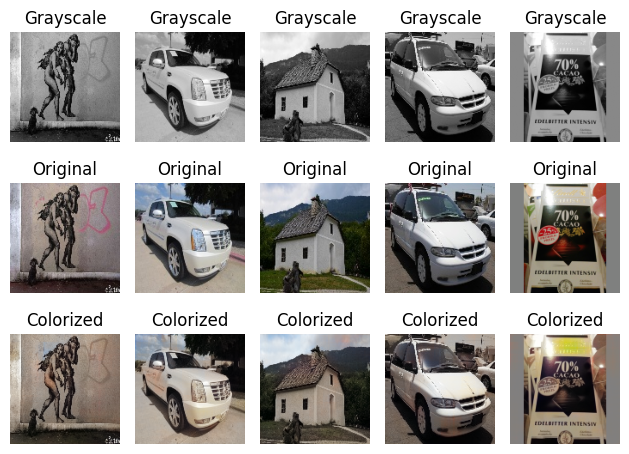

In [124]:
model = UNetColorization()
model.load_state_dict(torch.load('best_colorization_model.pth')) # Load saved model
model.to(device)

model.eval()

with torch.no_grad():
    sample_L, sample_ab = zip(*random.sample(list(test_ds), 5))
    for i in range(5):
        L = sample_L[i].unsqueeze(0).to(device)
        true_ab = sample_ab[i].to(device)
        pred_ab = model(L).squeeze(0).cpu()

        # Convert tensors to numpy arrays before passing to lab_to_rgb
        recon_true = lab_to_rgb(L.cpu().squeeze(0).squeeze(0), true_ab.cpu())
        recon_pred = lab_to_rgb(L.cpu().squeeze(0).squeeze(0), pred_ab.cpu())

        L_np = L.cpu().squeeze().numpy()  # shape: (128, 128)

        plt.subplot(3, 5, i+1)
        plt.imshow(L_np, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(recon_true)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(recon_pred)
        plt.title("Colorized")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Conclusion

We have successfully trained a U-Net style model for image colorization using the LAB color space. The visualizations show that the model is able to predict the color channels (a and b) given the luminance channel (L), resulting in plausible colorized images. The performance can potentially be further improved by training for more epochs or experimenting with different model architectures and hyperparameters.